<h1>Big Data Pokemon</h1>
<p>
    This jupyter notebook takes a dataset of pokemon images.
    it then sorts out  the images into the pokemns primary type using a csv file for refernece of the pokemon name and type.
    once the images are sorted by the pokemons type they are thne fed into a customized VGG16 model for training.
</p>

In [1]:
import glob
import os
import sys
import h5py
from PIL import Image, ImageFile
import pathlib
import csv
import cv2
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Dense, Dropout
from keras_preprocessing.image import ImageDataGenerator, img_to_array
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras import optimizers
import pandas as pd
from sklearn.datasets import load_files
import numpy as np
from keras.models import Model
import keras
import tensorflow as tf
from keras import models
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

print('Imports Successful.')

Using TensorFlow backend.


Imports Successful.


In [43]:
df = pd.read_csv('Pokemon.csv')
#extracting name and type from csv file
df1 = df[['Name','Type 1']]


for filename in glob.iglob('pokemonImages/*/*.jpg', recursive=True):
    if os.path.isfile(filename):  # filter dirs
        PokemonName = filename
        PokemonName = PokemonName.lstrip(PokemonName[:14])
        
        PokemonName = PokemonName.split('\\')[0]
        namelist = df['Name'].tolist()
        typeList = df['Type 1'].tolist()
        for name in namelist:
            if PokemonName == name:
                nameIndex = namelist.index(name)
                name = typeList[nameIndex]
                pathlib.Path('pokemonTypes/' + name).mkdir(parents=True, exist_ok=True)
                savePath = 'PokemonTypes/' + name + '/' + name.replace(" ", "") 
                     
        im = Image.open(filename)
        if im.mode in ("RGBA", "P"):
            im = im.convert("RGB")
        try:
            im.save(savePath, "JPEG", quality=80, optimize=True, progressive=True)
        except IOError:
            ImageFile.MAXBLOCK = im.size[0] * im.size[1]
            im.save(savePath, "JPEG", quality=80, optimize=True, progressive=True)

# Spliting the original pokemon dataset that is  sorted by pokemon names into a datset where they are seperated by their types

In [2]:
print('pokemon Images', len(glob.glob('pokemonImages/*/*.jpg', recursive=True)))

pokemon Images 10120


In [3]:
print('pokemon Types', len(glob.glob('pokemonTypes/*/*.jpg', recursive=True)))

pokemon Types 9777


In [77]:
print('number of images for each pokemon type')
print('Bug: ', len(glob.glob('pokemonTypes/Bug/*.jpg', recursive=True)))
print('Dragon: ',len(glob.glob('pokemonTypes/Dragon/*.jpg', recursive=True)))
print('Electric: ',len(glob.glob('pokemonTypes/Electric/*.jpg', recursive=True)))
print('Fairy: ', len(glob.glob('pokemonTypes/Fairy/*.jpg', recursive=True)))
print('Fighgting: ', len(glob.glob('pokemonTypes/Fighting/*.jpg', recursive=True)))
print('Fire: ',len(glob.glob('pokemonTypes/Fire/*.jpg', recursive=True)))
print('Ghost: ',len(glob.glob('pokemonTypes/Ghost/*.jpg', recursive=True)))
print('Grass: ', len(glob.glob('pokemonTypes/Grass/*.jpg', recursive=True)))
print('Ground: ', len(glob.glob('pokemonTypes/Ground/*.jpg', recursive=True)))
print('Ice: ', len(glob.glob('pokemonTypes/Ice/*.jpg', recursive=True)))
print('Normal: ', len(glob.glob('pokemonTypes/Normal/*.jpg', recursive=True)))
print('Poisom: ', len(glob.glob('pokemonTypes/Poison/*.jpg', recursive=True)))
print('Psychic: ', len(glob.glob('pokemonTypes/Psychic/*.jpg', recursive=True)))
print('Rock: ' ,len(glob.glob('pokemonTypes/Rock/*.jpg', recursive=True)))
print('Water: ' , len(glob.glob('pokemonTypes/Water/*.jpg', recursive=True)))


number of images for each pokemon type
Bug:  716
Dragon:  234
Electric:  643
Fairy:  108
Fighgting:  441
Fire:  915
Ghost:  173
Grass:  781
Ground:  508
Ice:  114
Normal:  1428
Poisom:  746
Psychic:  414
Rock:  570
Water:  1986


In [6]:
def load_dataset(path):
    data = load_files(path, categories=None)
    files = np.array(data['filenames'])
    labels = np.array(data['target'])
    # np.utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
    one_hot_targets = np_utils.to_categorical(labels)
    return files, labels, one_hot_targets



def resize_and_crop(path):
    desired_size = 100
    im = cv2.imread(path)
 
    
    old_size = im.shape[:2]  # old_size is in (height, width) format
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    # padding
    # color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT)
    return new_im


def normalize_image_inputs(image):
    norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_image


# get a list of images from a list of paths
def pathlist2imagelist(pathlist):
    imagelist = []
    for path in pathlist:
        # print("path =", path)
        # img = crop(path)
        img = resize_and_crop(path)
        img_norm = normalize_image_inputs(img)

        # preprocess image list to fit keras expected input format -  4D array (4D tensor) [nb_samples,rows,columns,channels]
        # convert the image pixels to a numpy array
        img_norm = img_to_array(img_norm)
        # prepare the image for the VGG model
        img_exp = np.expand_dims(img_norm, axis=0)

        imagelist.append(img_exp)
        # if img_norm[0].shape is not 100 or img_norm[1].shape is not 100 or img_norm[2].shape is not 3:
        # print("image shape: ",img_norm.shape, path)
    # print("IMagelist shape", imagelist[0].shape, imagelist[1].shape,imagelist[2].shape)
    imglist = np.vstack(imagelist)
    return imglist


print('methods loaded successfully')

methods loaded successfully


In [7]:
print('loading the datset...')

pokemon_files, pokemon_labels, pokemon_targets = load_dataset('pokemonTypes')

print('\ndataset loaded.')

loading the datset...

dataset loaded.


In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

print('done')

done


In [9]:
print(tf.__version__)

1.13.1


In [10]:
from tensorflow.keras.layers import LSTM


VGG16_model = VGG16(weights='imagenet', include_top=False, input_tensor=None, input_shape=(100,100,3), pooling=None, classes=15)


# Freeze all the layers which I don't want to retrain
for layer in VGG16_model.layers[:10]:
    layer.trainable = False

#Adding custom Layers
#Adding custom Layers
x = VGG16_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)
#output layer with 62 classes as possible predictions
predictions = Dense(15, activation="softmax")(x)


skf = StratifiedKFold(n_splits=10, random_state=12)
avg_loss = []
avg_acc = []
# Loop through the indices the split() method returns
for index, (train_index, test_index) in enumerate(skf.split(pokemon_files, pokemon_labels)):
    print("Training on fold " + str(index + 1) + "/10.............................................")
    # Generate batches from indices
    xtrain, xtest = pokemon_files[train_index], pokemon_files[test_index]
    # use one-hot vectors as labels
    ytrain, ytest = pokemon_targets[train_index], pokemon_targets[test_index]

    # Clear the model, and create it
    model = None
    model = Model(inputs=VGG16_model.input, outputs=predictions)

    
    #load best weights so far
    model.load_weights("pokemonWeights.hdf5")  #for VGG16


    print('\n\nCompiling Model.')
    # if your targets are one-hot encoded, use categorical_crossentropy, but if your targets are integers, use sparse_categorical_crossentropy
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.7),
                  metrics=['accuracy'])
   

    print('\n\nsetting  up checkpoints.')
    #create checkpoint after each epoch in the fitting process
    filepath = "pokemonWeights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False,
                                mode='max', period=1)
    callbacks_list = [checkpoint]

    print('\n\nLoading Images.')
    # open all the images from the xtrain and ytrain paths, crop and normalize them
    xtrain_imagelist = pathlist2imagelist(xtrain)
    xtest_imagelist = pathlist2imagelist(xtest)

    # fit the model - only a few epochs, to save time

    # fit the model with image augmentation
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
    # fit it on the data - this will calculate any statistics required to actually perform the transforms on the image data.
    datagen.fit(xtrain_imagelist)
    # steps_per_epoch * batch_size images will be loaded per each epoch
    model.fit_generator(datagen.flow(xtrain_imagelist, ytrain, batch_size=16), steps_per_epoch=450,
                        validation_data=(xtest_imagelist, ytest), epochs=6, callbacks=callbacks_list, verbose=1)

    print('\n\nEvaluationg model')
    # evaluate and store the accuracy
    loss, accuracy = model.evaluate(xtest_imagelist, ytest, verbose=1)
    avg_loss.append(loss)
    avg_acc.append(accuracy)

    # cross validation score-
    print("Average accuracy of model on the dev set = ", np.mean(avg_acc))

print('\n\nSaving Model.')
model.save('pokemonWeights.hdf5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Training on fold 1/10.............................................


Compiling Model.


setting  up checkpoints.


Loading Images.
Instructions for updating:
Use tf.cast instead.
Epoch 1/6
450/450 [==============================] - 27s 61ms/step - loss: 0.2152 - acc: 0.9349 - val_loss: 0.1391 - val_acc: 0.9513

Epoch 00001: val_acc improved from -inf to 0.95127, saving model to pokemonWeights.hdf5
Epoch 2/6
450/450 [==============================] - 24s 53ms/step - loss: 0.2064 - acc: 0.9351 - val_loss: 0.1220 - val_acc: 0.9553

Epoch 00002: val_acc improved from 0.95127 to 0.95533, saving model to pokemonWeights.hdf5
Epoch 3/6
450/450 [==============================] - 24s 53ms/step - loss: 0.2079 - acc: 0.9354 - val_loss: 0.1274 - val_acc: 0.9503

Epoch 00003: val_acc did not improve from 0.95533
Epo

Epoch 1/6
450/450 [==============================] - 26s 58ms/step - loss: 0.2034 - acc: 0.9358 - val_loss: 0.1671 - val_acc: 0.9529

Epoch 00001: val_acc improved from -inf to 0.95292, saving model to pokemonWeights.hdf5
Epoch 2/6
450/450 [==============================] - 24s 54ms/step - loss: 0.2047 - acc: 0.9340 - val_loss: 0.1276 - val_acc: 0.9632

Epoch 00002: val_acc improved from 0.95292 to 0.96315, saving model to pokemonWeights.hdf5
Epoch 3/6
450/450 [==============================] - 24s 54ms/step - loss: 0.2078 - acc: 0.9392 - val_loss: 0.1363 - val_acc: 0.9601

Epoch 00003: val_acc did not improve from 0.96315
Epoch 4/6
450/450 [==============================] - 24s 54ms/step - loss: 0.1975 - acc: 0.9364 - val_loss: 0.1148 - val_acc: 0.9642

Epoch 00004: val_acc improved from 0.96315 to 0.96418, saving model to pokemonWeights.hdf5
Epoch 5/6
450/450 [==============================] - 24s 54ms/step - loss: 0.1944 - acc: 0.9371 - val_loss: 0.1356 - val_acc: 0.9580

Epoch 0000

# Results for Training 

<b>After running the above code twice for a total of 360 epochs with 450 steps per epoch the following results were achieved.</b>


<b>After 300 epochs the below results were avheived</b><br>

Loss: 0.3670 <br>
Accuracy: 0.8771 <br>
Val_Loss: 0.3410 <br>
Val_Accuracy: 0.9063 <br>
    
<b>After running the model for an addition 60 epochs the below results were avheived (Total: 360 epochs)</b><br>
    
Loss: 0.2614 <br>
Accuracy: 0.9171 <br>
Val_Loss: 0.1916 <br>
Val_Accuracy: 0.9341 <br>

<b>After running the model for an addition 60 epochs the below results were avheived (Total: 420 epochs)</b><br>
    
Loss: 0.1671 <br>
Accuracy: 0.9490 <br>
Val_Loss: 0.1104 <br>
Val_Accuracy: 0.9598 <br>

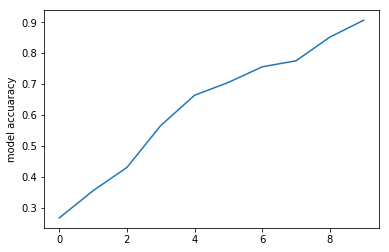

In [11]:
plt.plot(avg_acc)
plt.ylabel('model accuaracy')
plt.show()

# The above graph shows the plot of the accuracy whilst training the model after 300 epochs with 450 steps per epoch

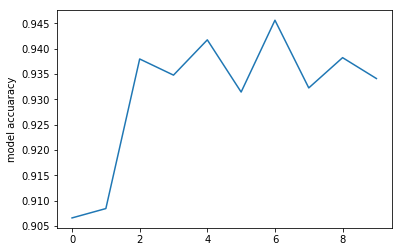

In [24]:
plt.plot(avg_acc)
plt.ylabel('model accuaracy')
plt.show()

# The above graph shows the plot of the accuracy after loading the saved model and training the model for a futher 60 epochs with 450 steps per epoch (Total epochs: 360)

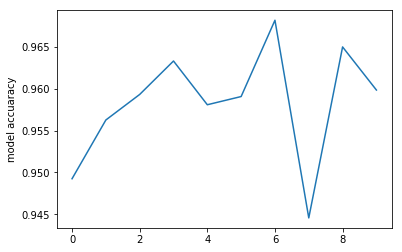

In [11]:
plt.plot(avg_acc)
plt.ylabel('model accuaracy')
plt.show()

# The above graph shows the plot of the accuracy after loading the saved model and training the model for a futher 60 epochs with 450 steps per epoch (Total epochs: 420)

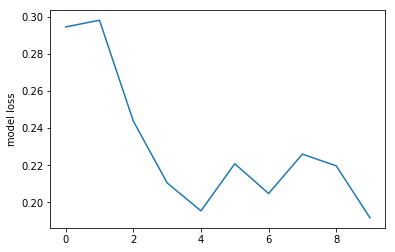

In [23]:
plt.plot(avg_loss)
plt.ylabel('model loss')
plt.show()

# The above graph showing the plot of the loss whilst training the model 

In [90]:
choices = {
    0: "Bug",
    1: "Dragon",
    2: "Electric",
    3: "Fairy",
    4: "Fighting",
    5: "Fire",
    6: "Ghost",
    7: "Grass",
    8: "Ground",
    9: "Ice",
    10: "Normal",
    11: "Poison",
    12: "Psychic",
    13: "Rock",
    14: "Water",
}

def getlabel(classnum):
    return choices.get(classnum, 'This is a unknown class')

<B>The above code maps the pokemon type to the class number it is classified as<b>
    

In [91]:
from keras.applications.densenet import preprocess_input
from keras_preprocessing.image import img_to_array
from keras.models import load_model

def getPrediction(path):
    img = path
    model = load_model('pokemonWeights.hdf5')
    img = resize_and_crop(img)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    predicted_classes = model.predict(img)
    predicted_class = predicted_classes.argmax(axis=-1)
    print('predicted class for ', path, 'is :' , getlabel(predicted_class[0]))

<b>The code above defines a method that takes a path to an image as a parameter. It then returns the predicted class for the image supplied<b>

In [92]:
getPrediction('TestImages/Nidoran.jpg')
print('######### should be: Poison\n')
getPrediction('TestImages/pikachu.jpg')
print('######### should be: Electric\n')
getPrediction('TestImages/Charizard.jpg')
print('######### should be: Fire\n')
getPrediction('TestImages/Zapdos.jpg')
print('######### should be: Electric\n')
getPrediction('TestImages/Smog.jpg')
print('######### should be: Poison\n')
getPrediction('TestImages/Download.jpg')
print('######### should be: Water\n')
getPrediction('TestImages/Dratini.jpg')
print('######### Should be: Dragon\n')
getPrediction('TestImages/Weedle.jpg')
print('######### should be: bug\n')
getPrediction('TestImages/Icenew.jpg')
print('######### should be: Ice')

predicted class for  TestImages/Nidoran.jpg is : Poison
######### should be: Poison

predicted class for  TestImages/pikachu.jpg is : Electric
######### should be: Electric

predicted class for  TestImages/Charizard.jpg is : Fire
######### should be: Fire

predicted class for  TestImages/Zapdos.jpg is : Electric
######### should be: Electric

predicted class for  TestImages/Smog.jpg is : Poison
######### should be: Poison

predicted class for  TestImages/Download.jpg is : Water
######### should be: Water

predicted class for  TestImages/Dratini.jpg is : Dragon
######### Should be: Dragon

predicted class for  TestImages/Weedle.jpg is : Bug
######### should be: bug

predicted class for  TestImages/Icenew.jpg is : Water
######### should be: Ice
